# Histogram of Oriented Gradients (HOG)

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Color Features

In [2]:
# Compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Extract features from a list of images
def get_color_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    image_features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)      

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    image_features.append(spatial_features)
    
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    image_features.append(hist_features)
    
    # Return list of feature vectors
    return np.concatenate(image_features)

# HOG + Color Features

In [3]:
def extract_single_image_features(image, color_space='RGB', spatial_size=(32, 32),
                                  hist_bins=32, orient=9, pix_per_cell=8, 
                                  cell_per_block=2, hog_channel='ALL',
                                  color_feat=True, hog_feat=True):
    # Create a list to append the feature vectors to
    image_features = []

    if hog_feat == True:
        # Extract HOG features and normalize the features        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(image.shape[2]):
                hog_features.append(get_hog_features(image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        image_features.append(hog_features)

    if color_feat == True:
        # Extract color features and normalize them
        color_features = get_color_features(image, cspace=color_space, 
                                            spatial_size=spatial_size,
                                            hist_bins=hist_bins)

        image_features.append(color_features)


    return np.concatenate(image_features)

def extract_image_features(image_files, color_space='RGB', spatial_size=(32, 32),
                           hist_bins=32, orient=9, pix_per_cell=8, 
                           cell_per_block=2, hog_channel='ALL',
                           color_feat=True, hog_feat=True):
    # Create a list to append the feature vectors to
    features = []

    for file in image_files:
        image = mpimg.imread(file)
        image_features = extract_single_image_features(image, color_space=color_space,
                                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                                       orient=orient, pix_per_cell=pix_per_cell,
                                                       cell_per_block=cell_per_block, 
                                                       hog_channel=hog_channel, color_feat=color_feat,
                                                       hog_feat=hog_feat)

        # Add the image feature vector to the feature list
        features.append(image_features)

    return features

# Test HOG and Color Features

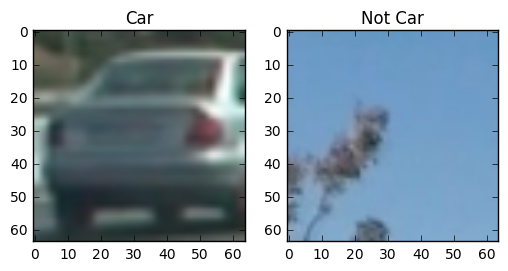

In [7]:
# Read Test Images
images = glob.glob('test_labeled_data/**/*.png',recursive=True)
test_cars = []
test_notcars = []

for image in images:
    if 'non-vehicles' in image:
        test_notcars.append(image)
    else:
        test_cars.append(image)

#Sample Vehicle and Non-Vehicle Image
import random
random_car = mpimg.imread(random.choice(test_cars))
plt.subplot(121)
plt.imshow(random_car)
plt.title("Car")

random_noncar = mpimg.imread(random.choice(test_notcars))
plt.subplot(122)
plt.imshow(random_noncar)
plt.title("Not Car")

plt.show()

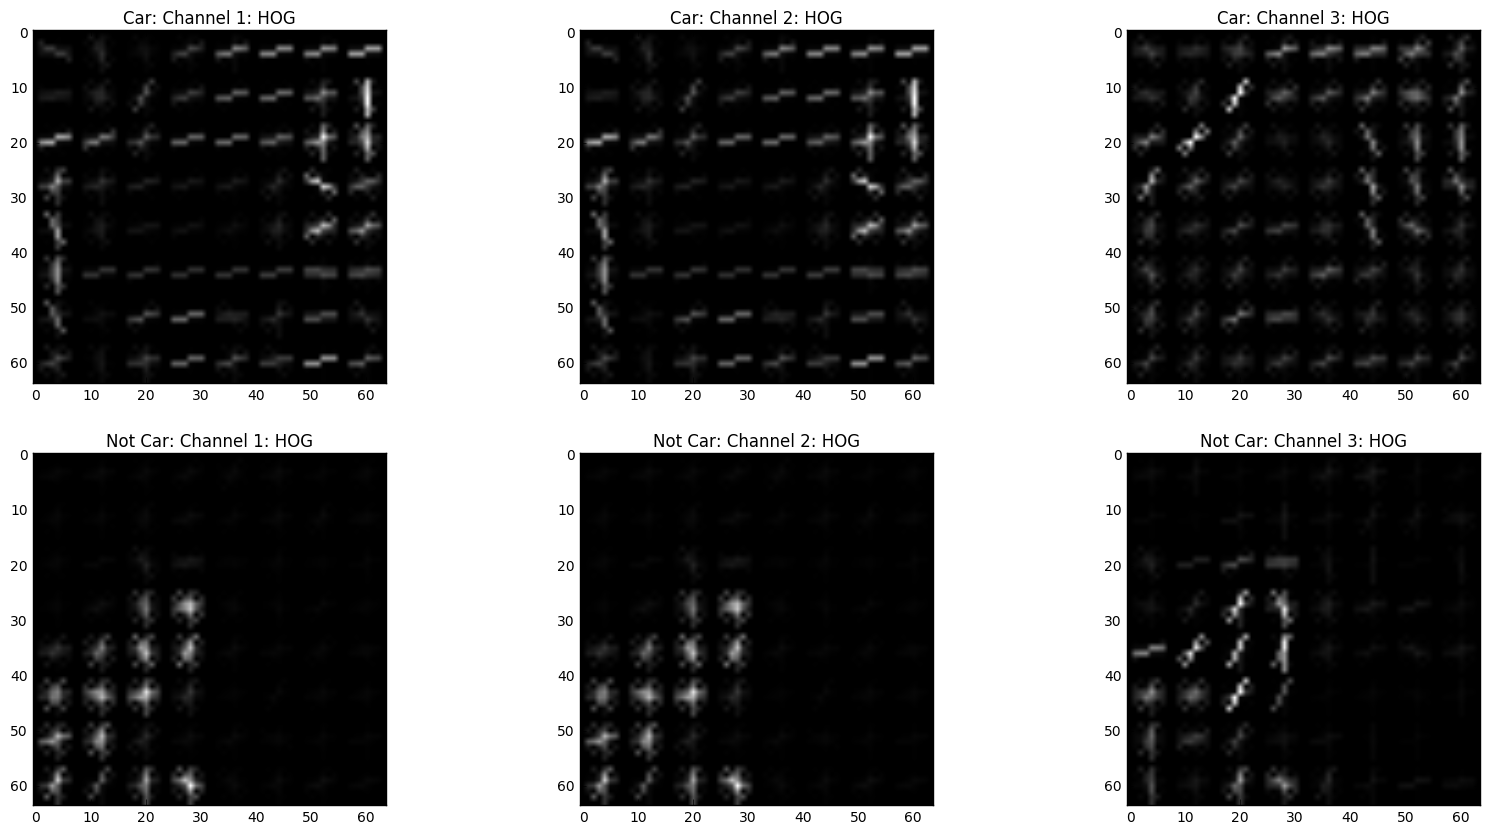

In [20]:
# Display HOG Feature: Car

plt.figure(figsize=(20,10))
random_car_ct = cv2.cvtColor(random_car, cv2.COLOR_RGB2YCrCb)
ch1 = random_car_ct[:,:,0]
ch2 = random_car_ct[:,:,1]
ch3 = random_car_ct[:,:,2]

fts, test_hog_image = get_hog_features(ch1, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
plt.subplot(231)
plt.imshow(test_hog_image, cmap="gray")
plt.title("Car: Channel 1: HOG")

fts, test_hog_image = get_hog_features(ch1, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
plt.subplot(232)
plt.imshow(test_hog_image, cmap="gray")
plt.title("Car: Channel 2: HOG")

fts, test_hog_image = get_hog_features(ch3, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
plt.subplot(233)
plt.imshow(test_hog_image, cmap="gray")
plt.title("Car: Channel 3: HOG")


# Display HOG Feature: Non-Car

random_noncar_ct = cv2.cvtColor(random_noncar, cv2.COLOR_RGB2YCrCb)
ch1 = random_noncar_ct[:,:,0]
ch2 = random_noncar_ct[:,:,1]
ch3 = random_noncar_ct[:,:,2]

fts, test_hog_image = get_hog_features(ch1, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
plt.subplot(234)
plt.imshow(test_hog_image, cmap="gray")
plt.title("Not Car: Channel 1: HOG")

fts, test_hog_image = get_hog_features(ch1, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
plt.subplot(235)
plt.imshow(test_hog_image, cmap="gray")
plt.title("Not Car: Channel 2: HOG")

fts, test_hog_image = get_hog_features(ch3, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
plt.subplot(236)
plt.imshow(test_hog_image, cmap="gray")
plt.title("Not Car: Channel 3: HOG")

plt.show()

# Train SVM Classifier

In [22]:
%matplotlib inline
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

images = glob.glob('labeled_data/**/*.png',recursive=True)
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Extract features
color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
color_feat=True
hog_feat=True

car_features = extract_image_features(cars, color_space=color_space, spatial_size=spatial_size,
                                      hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, hog_channel=hog_channel,
                                      color_feat=color_feat, hog_feat=hog_feat)
notcar_features = extract_image_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                      hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, hog_channel=hog_channel,
                                      color_feat=color_feat, hog_feat=hog_feat)
        
# Stack the car and not car features, create the output labels
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X)
scaled_x = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

27.65 Seconds to train SVC...
Test Accuracy of SVC =  0.982
5e-05 Seconds to predict 10 labels with SVC


# Define vehicle detection pipeline

In [23]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block):

    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = img_tosearch 

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initialize a list to append window positions to
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = []
            image_features = []
            
            hog_features.append(hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window])
            hog_features.append(hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window])
            hog_features.append(hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window])
            
            hog_features = np.ravel(hog_features)
            image_features.append(hog_features)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            color_features = get_color_features(subimg, cspace=color_space, 
                                            spatial_size=spatial_size,
                                            hist_bins=hist_bins)
            image_features.append(color_features)
            features = np.concatenate(image_features)
            
            test_features = scaler.transform(np.array(features).reshape(1, -1))

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)

                # Append window position to list
                startx = xbox_left
                starty = ytop_draw+ystart
                endx = xbox_left+win_draw
                endy = ytop_draw+win_draw+ystart
                window_list.append(((startx, starty), (endx, endy)))
                
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [24]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image. Discard bboxes that are too small
        if (((bbox[0][0] - bbox[1][0])**2) + ((bbox[0][1] - bbox[1][1])**2)) > 2500:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [48]:
def fast_process_image(image):
    global heatmaps
    global heatmap_sum
    global heatmap_draw
    
    box_list = []
    
    # Windows size 64
    box_list.extend(find_cars(image, ystart=400, ystop=500, scale=1.0, svc=svc, 
                                  scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block))
    # Windows size 96
    box_list.extend(find_cars(image, ystart=400, ystop=500, scale=1.5, svc=svc, 
                                  scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block))
    # Windows size 128
    box_list.extend(find_cars(image, ystart=450, ystop=600, scale=2.0, svc=svc, 
                                  scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block))
    

    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heatmaps.append(heat)
    
    heatmap_sum = heatmap_sum + heat
    
    # subtract off old heat map to keep running sum of last n heatmaps
    if len(heatmaps)>25:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum,0.0,1000000.0)
        
    # Apply threshold to help remove false positives
    heatmap_draw = apply_threshold(np.copy(heatmap_sum),15)
        
    # Find final boxes from heatmap using label function
    labels = label(heatmap_draw)
    result = draw_labeled_bboxes(np.copy(image), labels)
    return result
    

# Test Pipeline on a single frame

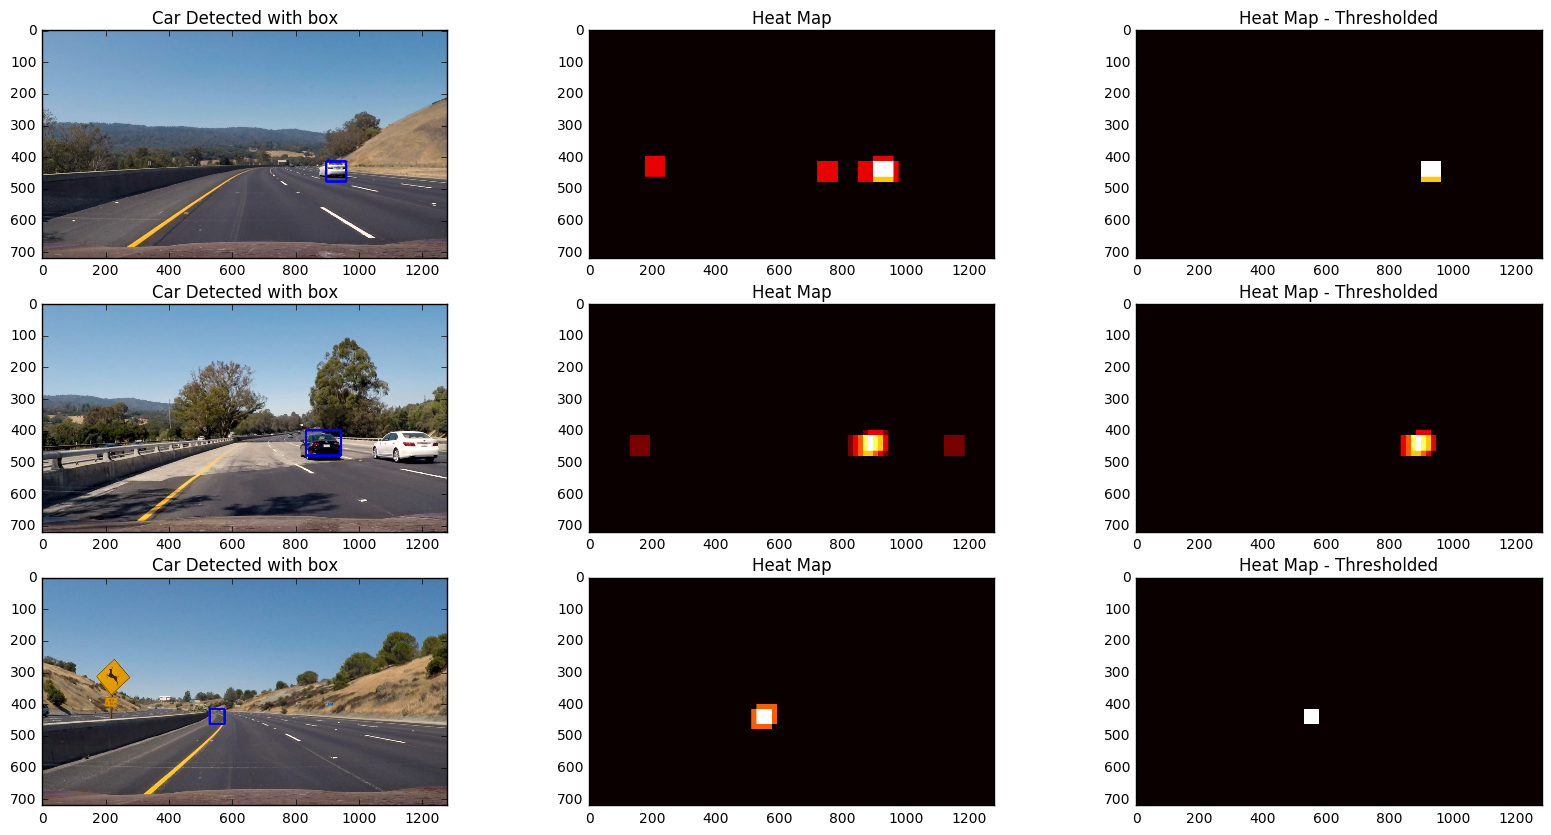

In [47]:
plt.figure(figsize=(20,10))
# Use threshold value of 1 above in fast_process_image to draw boxes for a single frame

heatmaps = []
heatmap_draw = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

plt.subplot(331)
plt.imshow(fast_process_image(mpimg.imread('test_images/test3.jpg')))
plt.title("Car Detected with box")

plt.subplot(332)
plt.imshow(heatmap_sum, cmap='hot')
plt.title("Heat Map")

plt.subplot(333)
plt.imshow(heatmap_draw, cmap='hot')
plt.title("Heat Map - Thresholded")


heatmaps = []
heatmap_draw = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

plt.subplot(334)
plt.imshow(fast_process_image(mpimg.imread('test_images/test4.jpg')))
plt.title("Car Detected with box")

plt.subplot(335)
plt.imshow(heatmap_sum, cmap='hot')
plt.title("Heat Map")

plt.subplot(336)
plt.imshow(heatmap_draw, cmap='hot')
plt.title("Heat Map - Thresholded")


heatmaps = []
heatmap_draw = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

plt.subplot(337)
plt.imshow(fast_process_image(mpimg.imread('test_images/test2.jpg')))
plt.title("Car Detected with box")

plt.subplot(338)
plt.imshow(heatmap_sum, cmap='hot')
plt.title("Heat Map")

plt.subplot(339)
plt.imshow(heatmap_draw, cmap='hot')
plt.title("Heat Map - Thresholded")


# Run the pipeline on video input

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

heatmaps = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)
#output_video = 'output_video_test.mp4'
#clip1 = VideoFileClip("test_video.mp4")
output_video = 'output_video_project.mp4'
clip1 = VideoFileClip("project_video.mp4")
#output_video = 'output_cut_video_project.mp4'
#clip1 = VideoFileClip("cut_video_project.mp4")
video_clip = clip1.fl_image(fast_process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output_video, audio=False)